## Import libraries and Data

In [31]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [32]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

df_coffee = df.loc[df['Product']=='Coffee',['Date','Quantity']].reset_index(drop=True)

del df

In [33]:
split_date = '2023-05-31'

df_train = df_coffee[df_coffee['Date']<=split_date].copy()

## Log Transform Model

In [34]:
scaler_log = StandardScaler()

In [35]:
df_coffee_log_scaled = df_train.copy()

df_coffee_log_scaled['Quantity_log_Transform'] = np.log(df_coffee_log_scaled['Quantity'])
df_coffee_log_scaled['Quantity_log_Scaled'] = scaler_log.fit_transform(df_coffee_log_scaled[['Quantity_log_Transform']])
df_coffee_log_scaled['Difference'] = df_coffee_log_scaled['Quantity_log_Scaled'].diff()


In [36]:
df_coffee_log_scaled

,Date,Quantity,Quantity_log_Transform,Quantity_log_Scaled,Difference
0,2023-01-01,375,5.926926,-0.622177,NaN
1,2023-01-02,376,5.929589,-0.612116,0.010061
2,2023-01-03,365,5.899897,-0.724285,-0.112169
3,2023-01-04,337,5.820083,-1.025805,-0.301520
4,2023-01-05,346,5.846439,-0.926239,0.099566
...,...,...,...,...,...
146,2023-05-27,747,6.616065,1.981229,-0.030222
147,2023-05-28,689,6.535241,1.675895,-0.305334
148,2023-05-29,550,6.309918,0.824678,-0.851217
149,2023-05-30,617,6.424869,1.258935,0.434257


###  Model Development

In [37]:
aic = []
bic = []
rsquared_adj = []

model_test = df_coffee_log_scaled.copy()
time_lag(model_test,'Difference',steps=31)
model_test= model_test.dropna()

for step in list(range(30)):
    
    f = []
    for i in list(range(step+1)):
        f.append(f't-{i+1}')

    target = model_test['Difference']
    features = model_test[f]
    features = sm.add_constant(features)

    log_scaled_mlr_model = sm.OLS(target,features).fit()

    aic.append(log_scaled_mlr_model.aic)
    bic.append(log_scaled_mlr_model.bic)
    rsquared_adj.append(log_scaled_mlr_model.rsquared_adj)


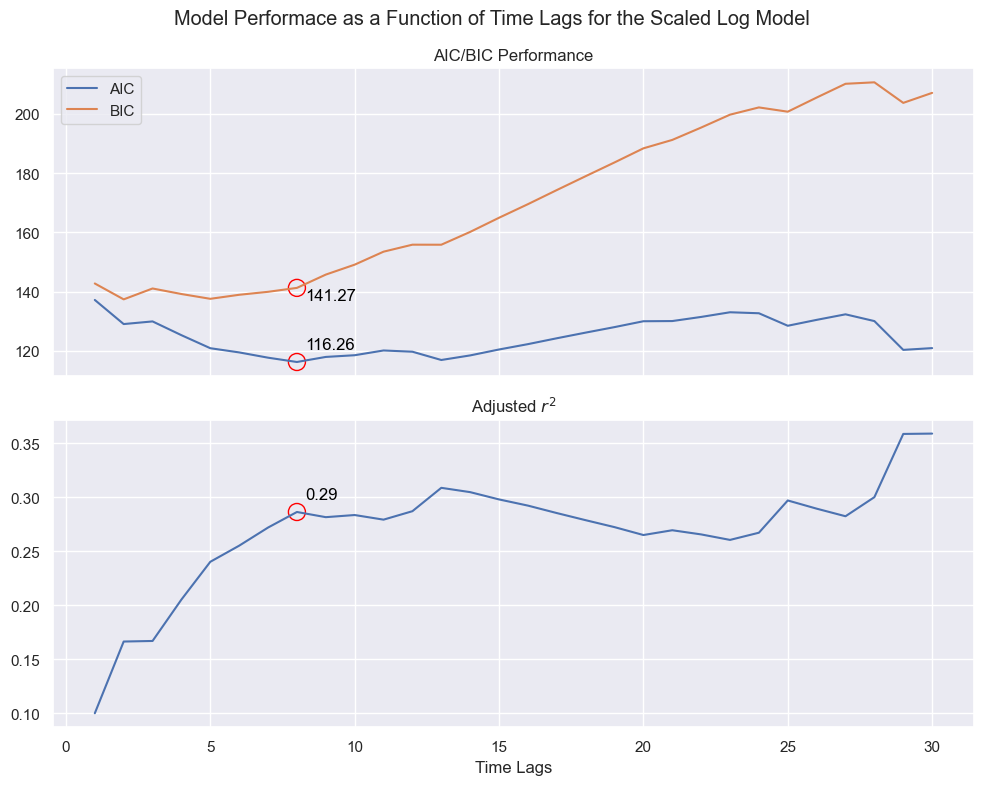

In [38]:
fig, ax = plt.subplots(2,1, figsize = (10,8),sharex=True)

lags = range(1, 31)

sns.lineplot(x= lags, y=aic, ax=ax[0],label='AIC')
sns.lineplot(x=lags, y= bic, ax=ax[0],label='BIC')
sns.lineplot(x=lags, y=rsquared_adj,ax=ax[1])

x_val = 8

y_aic = aic[x_val-1]
y_bic = bic[x_val-1]
y_r2  = rsquared_adj[x_val-1]

ax[0].scatter(x_val, y_aic, s=150, facecolors='none', edgecolors='red', linewidths=1)
ax[0].scatter(x_val, y_bic, s=150, facecolors='none', edgecolors='red', linewidths=1)
ax[1].scatter(x_val, y_r2,  s=150, facecolors='none', edgecolors='red', linewidths=1)

ax[0].text(x_val+0.3, y_aic+4.5, f"{y_aic:.2f}", color='black')
ax[0].text(x_val+0.3, y_bic, f"{y_bic:.2f}", color='black',va='top')
ax[1].text(x_val+0.3, y_r2+0.012,  f"{y_r2:.2f}", color='black')

fig.suptitle("Model Performace as a Function of Time Lags for the Scaled Log Model")
ax[0].set(title="AIC/BIC Performance")
ax[1].set(title='Adjusted $r^2$',xlabel = "Time Lags")


plt.tight_layout()
plt.savefig("Images/Diagnostics/Log_Model_performance_by_lags.png")

plt.show()

In [39]:
idx = 8

model_df = df_coffee_log_scaled.copy()
time_lag(model_df,'Difference',steps=idx)
model_df = model_df.dropna()

target = model_df['Difference']

f = []
for i in range(1,8+1):
    f.append(f't-{i}')

features = model_df[f]

features = sm.add_constant(features)

log_scaled_mlr_model = sm.OLS(target,features).fit()

log_scaled_mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     8.040
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           8.25e-09
Time:                        21:03:16   Log-Likelihood:                -64.787
No. Observations:                 142   AIC:                             147.6
Df Residuals:                     133   BIC:                             174.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0757      0.035      2.188      0.030       0.007       0.144
t-1           -0.6205      0.085     -7.277      0.000      -0.789      -0.452
t-2           -0.5170      0.098     -5.294      0.000      -0.710      -0.324
t-3           -0.4150      0.106     -3.906      0.000      -0.625      -0.205
t-4           -0.4932      0.106     -4.664      0.000      -0.702      -0.284
t-5           -0.4812      0.106     -4.549      0.000      -0.690      -0.272
t-6           -0.3221      0.107     -3.016      0.003      -0.533      -0.111
t-7           -0.2639      0.101     -2.625      0.010      -0.463      -0.065
t-8           -0.1417      0.087     -1.621      0.107      -0.315       0.031
==============================================================================
Omnibus:                        1.177   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.555   Jarque-Bera (JB):                1.024
Skew:                           0.208   Prob(JB):                        0.599
Kurtosis:                       2.998   Cond. No.                         6.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

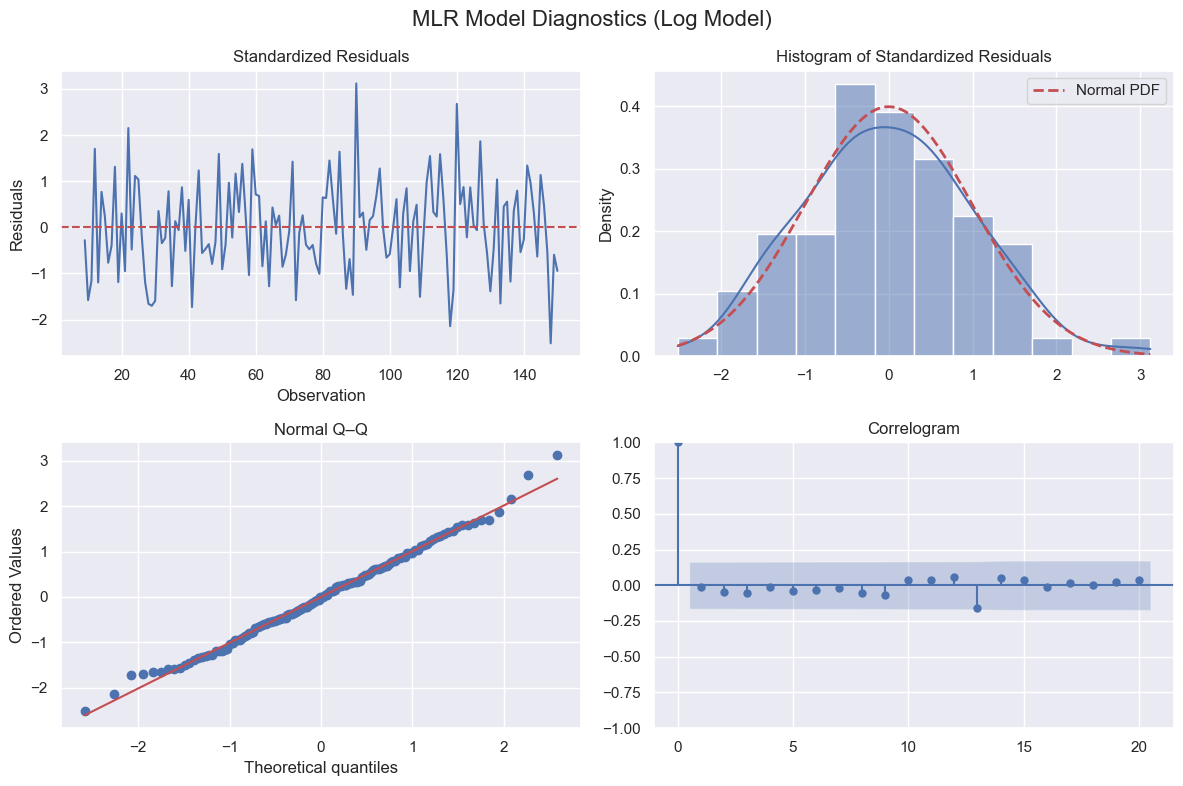

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("MLR Model Diagnostics (Log Model)", fontsize=16)

residuals = log_scaled_mlr_model.resid
resid_std = (residuals - residuals.mean()) / residuals.std()

#Residuals
axes[0, 0].plot(resid_std, linestyle='-')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Standardized Residuals")
axes[0, 0].set_xlabel("Observation")
axes[0, 0].set_ylabel("Residuals")

#Histogram
sns.histplot(resid_std, kde=True, stat="density", ax=axes[0, 1])

x = np.linspace(resid_std.min(), resid_std.max(), 200)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r--', linewidth=2, label="Normal PDF")
axes[0, 1].legend()
axes[0, 1].set_title("Histogram of Standardized Residuals")

#Q–Q plot
stats.probplot(resid_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q–Q")

#ACF plot
plot_acf(resid_std, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("Correlogram")

plt.tight_layout()

plt.savefig('Images/Diagnostics/Scaled_Log_MLR_Model_Diagnostics.png')

plt.show()

### Testing

#### One-Step Prediction

In [41]:
df_test = df_coffee.iloc[df_coffee.index[df_coffee['Date'] == split_date][0]-idx:,].copy()
df_test['Quantity_log_Transform'] = np.log(df_test['Quantity'])
df_test['Quantity_log_Scaled'] = scaler_log.transform(df_test[['Quantity_log_Transform']])
df_test['Difference'] = df_test['Quantity_log_Scaled'].diff()

time_lag(df_test,'Difference',steps=idx)

df_test = df_test.dropna()

df_test

,Date,Quantity,Quantity_log_Transform,Quantity_log_Scaled,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8
151,2023-06-01,785,6.665684,2.168676,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,-0.299810,-0.020531
152,2023-06-02,713,6.569481,1.805247,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,-0.299810
153,2023-06-03,731,6.594413,1.899434,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355
154,2023-06-04,735,6.599870,1.920049,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222
155,2023-06-05,709,6.563856,1.783993,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334
156,2023-06-06,685,6.529419,1.653899,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217
157,2023-06-07,658,6.489205,1.501981,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257
158,2023-06-08,742,6.609349,1.955858,0.453877,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303
159,2023-06-09,747,6.616065,1.981229,0.025371,0.453877,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044
160,2023-06-10,669,6.505784,1.564613,-0.416616,0.025371,0.453877,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430


In [42]:
predictors = df_test.filter(like='t-')

predictors = sm.add_constant(predictors)

In [43]:
df_test['pred'] = log_scaled_mlr_model.predict(predictors)

In [44]:
df_test

,Date,Quantity,Quantity_log_Transform,Quantity_log_Scaled,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,pred
151,2023-06-01,785,6.665684,2.168676,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,-0.299810,-0.020531,0.354561
152,2023-06-02,713,6.569481,1.805247,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,-0.299810,-0.159753
153,2023-06-03,731,6.594413,1.899434,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,0.071427
154,2023-06-04,735,6.599870,1.920049,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,-0.018521
155,2023-06-05,709,6.563856,1.783993,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.156251
156,2023-06-06,685,6.529419,1.653899,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.150004
157,2023-06-07,658,6.489205,1.501981,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.010840
158,2023-06-08,742,6.609349,1.955858,0.453877,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.109105
159,2023-06-09,747,6.616065,1.981229,0.025371,0.453877,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.086560
160,2023-06-10,669,6.505784,1.564613,-0.416616,0.025371,0.453877,-0.151919,-0.130094,-0.136056,0.020615,0.094187,-0.363430,0.037980


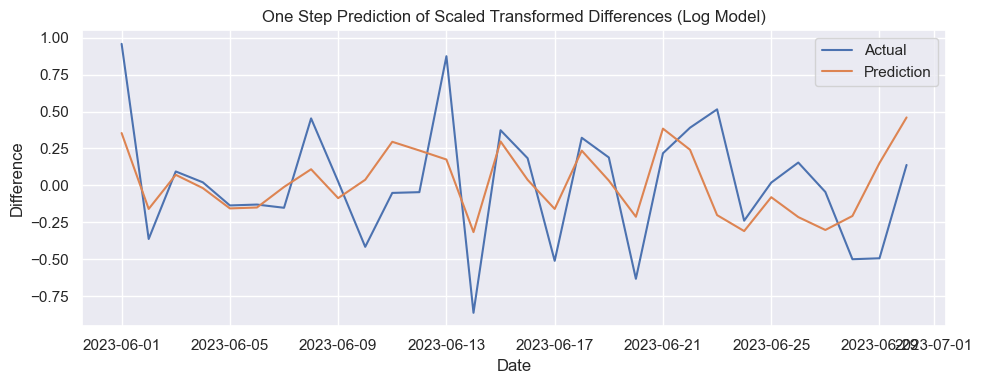

In [45]:
plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test, x='Date', y='Difference',label = 'Actual')
ax = sns.lineplot(data=df_test, x='Date', y='pred', label = 'Prediction')
ax.set(title = "One Step Prediction of Scaled Transformed Differences (Log Model)")

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Coffee_Single_Step_Differenced.png')

plt.show()

In [46]:
df_coffee_log_scaled.tail(5)

,Date,Quantity,Quantity_log_Transform,Quantity_log_Scaled,Difference
146,2023-05-27,747,6.616065,1.981229,-0.030222
147,2023-05-28,689,6.535241,1.675895,-0.305334
148,2023-05-29,550,6.309918,0.824678,-0.851217
149,2023-05-30,617,6.424869,1.258935,0.434257
150,2023-05-31,609,6.411818,1.209632,-0.049303


In [47]:
last_value = df_coffee_log_scaled['Quantity_log_Scaled'][150]

print(f'Last known value: {last_value:.6f}')

Last known value: 1.209632


In [48]:
df_test_rollup = df_test[['Date', 'Quantity','Quantity_log_Scaled','Difference','pred']].copy()

#add the differences starting with the last scaled transformed value (5-31-23) -> df_coffee_bc_scaled['Quantity_BC_Scaled'][150]
df_test_rollup['pred_undifferenced'] = df_test_rollup['pred'].cumsum() + last_value

#undo scaling
df_test_rollup['Undifferenced Unscaled'] = scaler_log.inverse_transform(df_test_rollup[['pred_undifferenced']])

#undo Box-Cox transform
df_test_rollup['Predicted Quantity'] = np.exp(df_test_rollup['Undifferenced Unscaled'])
df_test_rollup = df_test_rollup[['Date','Quantity','Predicted Quantity']]

df_test_rollup


,Date,Quantity,Predicted Quantity
151,2023-06-01,785,668.925730
152,2023-06-02,713,641.228172
153,2023-06-03,731,653.467262
154,2023-06-04,735,650.271464
155,2023-06-05,709,623.924483
156,2023-06-06,685,599.635627
157,2023-06-07,658,597.917409
158,2023-06-08,742,615.437521
159,2023-06-09,747,601.496293
160,2023-06-10,669,607.574040


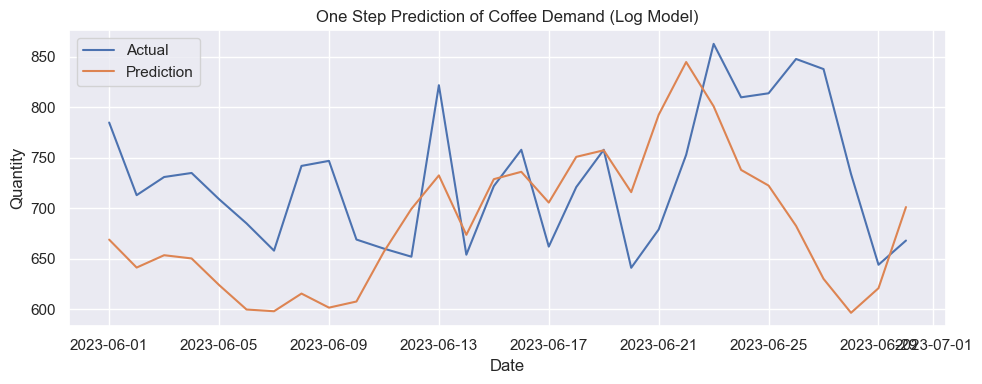

In [49]:
plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test_rollup, x='Date', y='Quantity',label ="Actual")
ax = sns.lineplot(data=df_test_rollup, x='Date', y='Predicted Quantity', label = 'Prediction')
ax.set(title = "One Step Prediction of Coffee Demand (Log Model)")

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Coffee_Single_Step_Rollup.png')

plt.show()

In [50]:
mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_test_rollup['Predicted Quantity'])*100

print(f'One Step Quantity MAPE: {mape:.2f}%')

One Step Quantity MAPE: 10.07%


### True June Prediction

In [51]:
test_dates = pd.date_range('2023-06-01', '2023-06-30', freq='D')

In [52]:
df_test.head()

,Date,Quantity,Quantity_log_Transform,Quantity_log_Scaled,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,pred
151,2023-06-01,785,6.665684,2.168676,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,-0.299810,-0.020531,0.354561
152,2023-06-02,713,6.569481,1.805247,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,-0.299810,-0.159753
153,2023-06-03,731,6.594413,1.899434,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,0.396355,0.071427
154,2023-06-04,735,6.599870,1.920049,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.030222,-0.018521
155,2023-06-05,709,6.563856,1.783993,-0.136056,0.020615,0.094187,-0.363430,0.959044,-0.049303,0.434257,-0.851217,-0.305334,-0.156251


In [53]:

latest_lags = list(df_test.iloc[0][['t-1','t-2','t-3','t-4','t-5','t-6','t-7','t-8']])

lags = [f't-{i}' for i in range(1, 9)]

forecast_diffs = []

for _ in range(len(test_dates)):
    X_new = pd.DataFrame([latest_lags], columns=lags)
    X_new = sm.add_constant(X_new, has_constant='add')
    
    y_pred = log_scaled_mlr_model.predict(X_new)[0]
    forecast_diffs.append(y_pred)
    
    # Update lag list for next day (push new prediction, drop oldest)
    latest_lags = [y_pred] + latest_lags[:-1]

    

In [54]:
df_forecast = pd.DataFrame({
    'Date': test_dates,
    'Predicted_Difference': forecast_diffs
})

In [55]:
df_forecast
df_forecast['Re-Summed'] = df_forecast['Predicted_Difference'].cumsum() + last_value

df_forecast['Unscaled'] = scaler_log.inverse_transform(df_forecast[['Re-Summed']])

df_forecast['Predicted Quantity'] = np.exp(df_forecast['Unscaled'])

df_forecast

,Date,Predicted_Difference,Re-Summed,Unscaled,Predicted Quantity
0,2023-06-01,0.354561,1.564193,6.505673,668.925730
1,2023-06-02,0.215324,1.779518,6.562671,708.160559
2,2023-06-03,0.024812,1.804330,6.569239,712.826997
3,2023-06-04,-0.023791,1.780539,6.562941,708.351996
4,2023-06-05,-0.034877,1.745662,6.553709,701.842412
5,2023-06-06,-0.155619,1.590043,6.512516,673.518580
6,2023-06-07,-0.078451,1.511592,6.491749,659.676256
7,2023-06-08,0.063121,1.574714,6.508458,670.791117
8,2023-06-09,0.055236,1.629950,6.523079,680.671044
9,2023-06-10,0.105469,1.735419,6.550998,699.942077


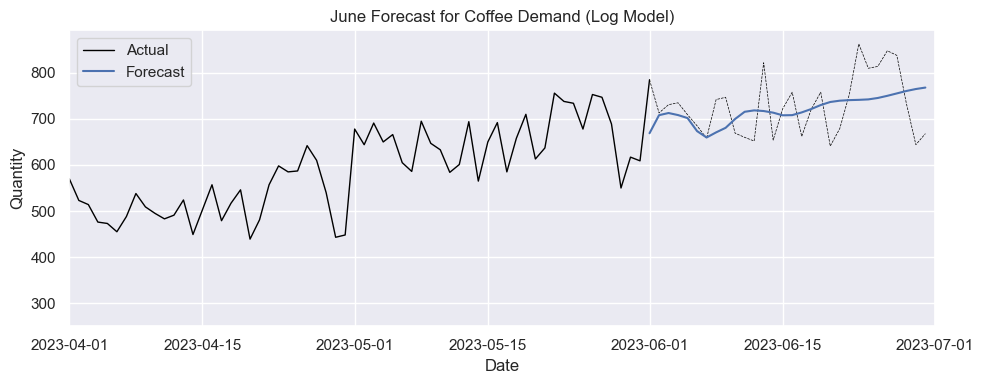

In [56]:
plt.figure(figsize=(10,4))

ax = sns.lineplot(data=df_coffee[df_coffee['Date']<= '2023-06-01'], x='Date',y='Quantity',c='black', label = 'Actual',linewidth = 1)
ax = sns.lineplot(data=df_coffee[df_coffee['Date'] >= '2023-06-01'], x='Date',y='Quantity',c='black',linewidth = 0.5, linestyle = '--')
ax = sns.lineplot(data=df_forecast, x='Date',y='Predicted Quantity',label='Forecast')

ax.set(title = "June Forecast for Coffee Demand (Log Model)")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-01'))

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Coffee_June_Forecast.png')

plt.show()

In [57]:
forecast_mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_forecast['Predicted Quantity'])*100

print(f'Final Forecast MAPE: {forecast_mape:.2f}%')

Final Forecast MAPE: 7.45%


### July Forecast

In [58]:
coffee_july_forecast = forecast_demand(df_coffee, '2023-07-01','2023-07-31',idx = 8, style= 'log')

coffee_july_forecast.to_csv('Results/coffee_july_forecast.csv')

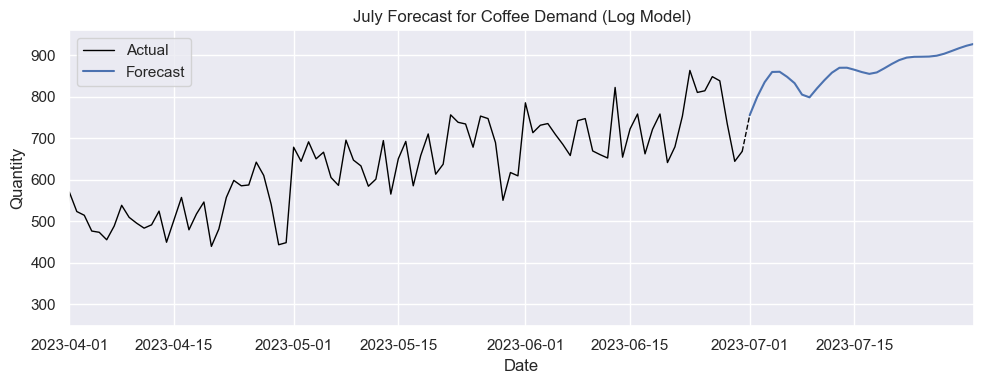

In [59]:
plt.figure(figsize=(10,4))

bridge_df = pd.DataFrame({'Date':[np.datetime64('2023-06-30'),np.datetime64('2023-07-01')],
                          'Quant':[df_coffee['Quantity'][max(df_coffee.index)],coffee_july_forecast['Predicted Quantity'][0]]})

ax = sns.lineplot(data=df_coffee, x='Date',y='Quantity',c='black', label = 'Actual',linewidth = 1)
ax = sns.lineplot(data=coffee_july_forecast, x='Date',y='Predicted Quantity',label='Forecast')
ax = sns.lineplot(data=bridge_df, x='Date',y='Quant', c='black', linestyle = '--', linewidth =1)

ax.set(title = "July Forecast for Coffee Demand (Log Model)")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-31'))

plt.tight_layout()
plt.savefig('Images/Forecasts/Log_Coffee_July Forecast.png')

plt.show()